In [186]:
from math import sqrt
import regex as re
import os
from glob import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
import torch
import transformers as ppb
import warnings

from xgboost import XGBClassifier, XGBRFClassifier, XGBRegressor, XGBRFRegressor
from xgboost import plot_importance
from xgboost import plot_importance
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

## Interspeech 2020 Challenge
Deadline: May 8th submission of predictions and paper.

Main Webpage: http://www.interspeech2020.org/index.php?m=content&c=index&a=lists&catid=66

Challenge Webpage: http://www.homepages.ed.ac.uk/sluzfil/ADReSS/

# Initial Plan
Only using the transcripts:
- [x] Simple clean and join all sentences, classifiy using DistillBERT, (BERT), (RoBERTa)   ## Done

## Further Feature Engineering:
### Time dimension
- Embed time total time taken - parse time blocks, take first and last
- Embed total time taken per sentence
- Time before starting speech
- Time in between each sentence
- Average / min / max / median time of sentence
- use of special characters
- number of sentences spoken

### Linguistic Features
- Embed special character tokens in speech, pauses etc. (not sure if this needed, tokenzier / and
- classify on a sentence level??
- Also use the Interviewer INV, questions / speech / time...
- Use POS Tags: as OHE vector

## Demographics
- Gender
- Age

## Fine-tuning BERT(-esque) models on spontaneous speech datasets
- fine-tune and re-classify using other spontaneous speech datasets: 

### Further work on
- Analysis of what roBERTa has actually learned in the attention heads

In [112]:
prob_ad_dir = '../train/transcription/cd/*'
controls_dir = '../train/transcription/cc/*'

In [113]:
def extract_data(file_name):
    par = {}
    par['id'] = file_name.split('/')[-1].split('.cha')[0]
    f = iter(open(file_name))
    l = next(f)
    speech = []
    try:
        curr_speech = ''
        while (True):
            if l.startswith('@ID'):
                participant = [i.strip() for i in l.split('|')]
                if participant[2] == 'PAR':
                    par['mmse'] = '' if len(participant[8]) == 0 else float(participant[8])
                    par['sex'] = participant[4][0]
                    par['age'] = int(participant[3].replace(';', ''))
            if l.startswith('*PAR:') or l.startswith('*INV'):
                curr_speech = l
            elif len(curr_speech) != 0 and not(l.startswith('%') or l.startswith('*')):
                curr_speech += l
            elif len(curr_speech) > 0:
                speech.append(curr_speech)
                curr_speech = ''
            l = next(f)
    except StopIteration:
        pass

    clean_par_speech = []
    clean_all_speech = []
    speech_time_segments = []
    is_par = False
    for s in speech:
        def _clean(s):
            speech_time_segments.append([*map(int, re.search('\x15(\d*_\d*)\x15', s).groups()[0].split('_'))])
            s = re.sub('\x15\d*_\d*\x15', '', s) # remove time block 
            s = re.sub('\[.*\]', '', s) # remove other speech artifacts [.*]
            s = s.strip()
            s = re.sub('\t|\n|<|>', '', s) # remove tab, new lines, inferred speech??, ampersand, &
            return s
        
        if s.startswith('*PAR:'):
            is_par = True
        elif s.startswith('*INV:'):
            is_par = False
            s = re.sub('\*INV:\t', '', s) # remove prefix
        if is_par:
            s = re.sub('\*PAR:\t', '', s) # remove prefix    
            clean_par_speech.append(_clean(s))
        clean_all_speech.append(_clean(s))
    
    par['speech'] = speech
    par['clean_speech'] = clean_all_speech
    par['clean_par_speech'] = clean_par_speech
    par['joined_all_speech'] = ' '.join(clean_all_speech)
    par['joined_all_par_speech'] = ' '.join(clean_par_speech)
    
    # sentence times
    par['per_sent_times'] = [speech_time_segments[i][1] - speech_time_segments[i][0] for i in range(len(speech_time_segments))]
    par['total_time'] =  speech_time_segments[-1][1] - speech_time_segments[0][0]
    par['time_before_par_speech'] = speech_time_segments[0][0]
    par['time_between_sents'] = [0 if i == 0 else max(0, speech_time_segments[i][0] - speech_time_segments[i-1][1]) 
                                 for i in range(len(speech_time_segments))]
    return par

In [114]:
def parse_train_data():
    return _parse_data('../data/train')
    
def parse_test_data():
    return _parse_data('../data/test')

def parse_pre_train_data():
    return _parse_data('/data/train')

def _parse_data(data_dir):
    prob_ad_dir = f'{data_dir}/transcription/cd/*'
    controls_dir = f'{data_dir}/transcription/cc/*'
    
    prob_ad = [extract_data(fn) for fn in glob(prob_ad_dir)]
    controls = [extract_data(fn) for fn in glob(controls_dir)]
    controls_df = pd.DataFrame(controls)
    prob_ad_df = pd.DataFrame(prob_ad)
    controls_df['ad'] = 0
    prob_ad_df['ad'] = 1
    df = pd.concat([controls_df, prob_ad_df]).sample(frac=1).reset_index(drop=True)
    return df

In [115]:
train_df = parse_train_data()

In [242]:
segmented_speech = train_df.apply(lambda r: pd.DataFrame({'id': r.id, 'speech_sent': r.clean_par_speech, 'ad': r.ad, 'mmse': r.mmse}), axis=1).tolist()

In [280]:
# explode out each segment into AD / control segments
# Do not shuffle, as parent level segments have already been shuffled?
train_df_segments = pd.concat(segmented_speech).reset_index(drop=True)

### Base-line TF-IDF -> GBDT / SVM Models

In [119]:
random_state = 42

In [120]:
def cv10_avg(score, model, features, labels):
    return round(cross_val_score(model, features, labels, cv=10, scoring=score).sum() / 10, 2)

In [272]:
def baseline_models(text: pd.Series, labels: list, mmse: list, xgb=True):
    ## AD Classification Pred
    # sklearn pipeline
    param_space = {
        'vec__max_features': [100, 500, 1000, 2000, 10000],
        'vec__stop_words': ['english', None],
        'vec__analyzer': ['word', 'char'],
        'vec__sublinear_tf': [True, False]       
    }    
    if xgb:
        param_space['clf__n_estimators'] = [100, 200, 500]  
        param_space['clf__max_depth'] = [3, 5, 10]
    else:
        param_space['clf__C'] = [0.1, 0.5, 1.]              
        param_space['clf__kernel'] = ['rbf', 'sigmoid']    

    clf_pipe = Pipeline([
        ('vec', TfidfVectorizer()),
        ('clf', XGBClassifier()) if xgb else ('clf', SVC())
    ])
    train_features, test_features, train_labels, test_labels = train_test_split(text, labels, random_state=random_state, test_size=0.2)
    search = GridSearchCV(clf_pipe, param_space, cv=5, n_jobs=6)
    search.fit(train_features, train_labels)

    clf_pipe.set_params(**search.best_params_)
    print(search.best_params_)
    clf_pipe.fit(train_features, train_labels)
    preds = clf_pipe.predict(test_features)
    print('prec, rec, f1 test', precision_recall_fscore_support(test_labels, preds))
    print(f'accu:{cv10_avg("accuracy", clf_pipe, text, labels)}')
    print(f'prec:{cv10_avg("precision", clf_pipe, text, labels)}')
    print(f'rec:{cv10_avg("recall", clf_pipe, text, labels)}')
    print(f'f1:{cv10_avg("f1", clf_pipe, text, labels)}')

    ## MMSE Regression Pred
    reg_features, reg_scores = text.drop([i for i, s in enumerate(mmse) if s == '']).reset_index(drop=True), [s for s in mmse if s != '']
    train_features, test_features, train_scores, test_scores = train_test_split(reg_features, reg_scores, random_state=random_state, test_size=0.2)

    # sklearn pipeline
    param_space = {
        'vec__max_features': [100, 500, 1000, 2000, 10000],
        'vec__stop_words': ['english', None],
        'vec__analyzer': ['word', 'char'],
        'vec__sublinear_tf': [True, False]
    }    
    if xgb:
        param_space['clf__n_estimators'] = [100, 200, 500]  
        param_space['clf__max_depth'] = [3, 5, 10]  
    else:
        param_space['clf__C'] = [0.1, 0.5, 1.]              
        param_space['clf__kernel'] = ['rbf', 'sigmoid']   

    rgs_pipe = Pipeline([
        ('vec', TfidfVectorizer()),
        ('clf', XGBRegressor()) if xgb else ('clf', SVR())
    ])

    search = GridSearchCV(rgs_pipe, param_space, cv=5, n_jobs=6)
    search.fit(train_features, train_scores)

    rgs_pipe.set_params(**search.best_params_)
    print(search.best_params_)
    rgs_pipe.fit(train_features, train_scores)
    preds = rgs_pipe.predict(test_features)
    print('rmse test:', sqrt(mean_squared_error(test_scores, preds)))
    print('rmse cv:', cross_val_score(rgs_pipe, reg_features, reg_scores, cv=10, scoring='neg_root_mean_squared_error').sum() / 10)

    return clf_pipe, rgs_pipe

In [273]:
# SVM - par speech only
clf_svm, rgs_svm = baseline_models(train_df.joined_all_par_speech, train_df.ad,  train_df.mmse, xgb=False)

{'clf__C': 1.0, 'clf__kernel': 'rbf', 'vec__analyzer': 'word', 'vec__max_features': 1000, 'vec__stop_words': None, 'vec__sublinear_tf': True}
prec, rec, f1 test (array([0.84615385, 1.        ]), array([1.        , 0.81818182]), array([0.91666667, 0.9       ]), array([11, 11]))
accu:0.86
prec:0.91
rec:0.84
f1:0.85
{'clf__C': 1.0, 'clf__kernel': 'sigmoid', 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': True}
rmse test: 6.715101139865216
rmse cv: -5.828961412118949


In [274]:
# SVM - par + inv speech
clf_svm, rgs_svm = baseline_models(train_df.joined_all_speech, train_df.ad, train_df.mmse, xgb=False)

{'clf__C': 1.0, 'clf__kernel': 'rbf', 'vec__analyzer': 'word', 'vec__max_features': 500, 'vec__stop_words': None, 'vec__sublinear_tf': True}
prec, rec, f1 test (array([0.83333333, 0.9       ]), array([0.90909091, 0.81818182]), array([0.86956522, 0.85714286]), array([11, 11]))
accu:0.88
prec:0.92
rec:0.87
f1:0.87
{'clf__C': 1.0, 'clf__kernel': 'sigmoid', 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': None, 'vec__sublinear_tf': True}
rmse test: 6.674597551339369
rmse cv: -5.734230349579695


In [248]:
# XGBoost - par speech only
clf_xgb_par, rgs_xgb_par = baseline_models(train_df.joined_all_par_speech, train_df.ad, train_df.mmse, xgb=True)

{'clf__max_depth': 5, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 1000, 'vec__stop_words': None, 'vec__sublinear_tf': True}
prec, rec, f1 test (array([0.75, 0.8 ]), array([0.81818182, 0.72727273]), array([0.7826087 , 0.76190476]), array([11, 11]))
accu:0.84
prec:0.86
rec:0.84
f1:0.84
{'clf__max_depth': 3, 'clf__n_estimators': 200, 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': False}
rmse test: 6.537925257229833
rmse cv: -5.561295795181303


In [249]:
# XGBoost - par + inv speech
clf_xgb_all, rgs_xgb_all = baseline_models(train_df.joined_all_par_speech, train_df.ad, train_df.mmse, xgb=True)

{'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': False}
prec, rec, f1 test (array([0.75, 0.8 ]), array([0.81818182, 0.72727273]), array([0.7826087 , 0.76190476]), array([11, 11]))
accu:0.79
prec:0.8
rec:0.82
f1:0.79
{'clf__max_depth': 3, 'clf__n_estimators': 200, 'vec__analyzer': 'char', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': False}
rmse test: 6.370420306954228
rmse cv: -5.603149994529027


In [282]:
# SVM - segmented
clf_svm, rgs_svm = baseline_models(train_df_segments.speech_sent, train_df_segments.ad, train_df_segments.mmse, xgb=False) 

{'clf__C': 1.0, 'clf__kernel': 'rbf', 'vec__analyzer': 'word', 'vec__max_features': 1000, 'vec__stop_words': None, 'vec__sublinear_tf': True}
prec, rec, f1 test (array([0.75384615, 0.73493976]), array([0.69014085, 0.79220779]), array([0.72058824, 0.7625    ]), array([142, 154]))
accu:0.72
prec:0.72
rec:0.73
f1:0.72
{'clf__C': 1.0, 'clf__kernel': 'sigmoid', 'vec__analyzer': 'word', 'vec__max_features': 500, 'vec__stop_words': None, 'vec__sublinear_tf': False}
rmse test: 7.318767768806731
rmse cv: -7.0807403858703735


In [283]:
# XGBoost - segmented
clf_svm, rgs_svm = baseline_models(train_df_segments.speech_sent, train_df_segments.ad, train_df_segments.mmse, xgb=True) 

{'clf__max_depth': 3, 'clf__n_estimators': 200, 'vec__analyzer': 'word', 'vec__max_features': 500, 'vec__stop_words': None, 'vec__sublinear_tf': False}
prec, rec, f1 test (array([0.65753425, 0.69333333]), array([0.67605634, 0.67532468]), array([0.66666667, 0.68421053]), array([142, 154]))
accu:0.68
prec:0.68
rec:0.71
f1:0.69
{'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 1000, 'vec__stop_words': None, 'vec__sublinear_tf': False}
rmse test: 6.964259148338462
rmse cv: -6.996732925985971


In [217]:
def feat_impor(pipe):
    feat_impor = [(pipe.steps[0][1].get_feature_names()[i], pipe.steps[1][1].feature_importances_[i]) for i in np.argsort(pipe.steps[1][1].feature_importances_)[::-1][0:20]]
    labs = [i[0] for i in feat_impor]
    scores = [i[1] for i in feat_impor]
    return labs, scores

In [250]:
def plt_feats(clf_labels, clf_impor, rgs_labels, rgs_impor):
    fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(10, 5))
    ax1.barh(range(len(clf_impor)), clf_impor, label='AD Classification')
    ax1.set_yticks(range(len(clf_labels)))
    ax1.set_yticklabels(clf_labels)
    ax1.set_ylabel('TF-IDF Feature')
    ax1.set_xlabel('Feature Importance')

    ax2.barh(range(len(rgs_labels)), rgs_impor, label='MMSE Regression')
    ax2.set_yticks(range(len(rgs_labels)))
    ax2.set_yticklabels(rgs_labels)
    ax2.set_ylabel('TF-IDF Feature')
    ax2.set_xlabel('Feature Importance')

    # plt.legend([bar1, bar2], [bar1.get_label(), bar2.get_label()], fontsize=12)
    plt.tight_layout()
    plt.savefig('./feat_impor_xgboost.png')
    plt.show()

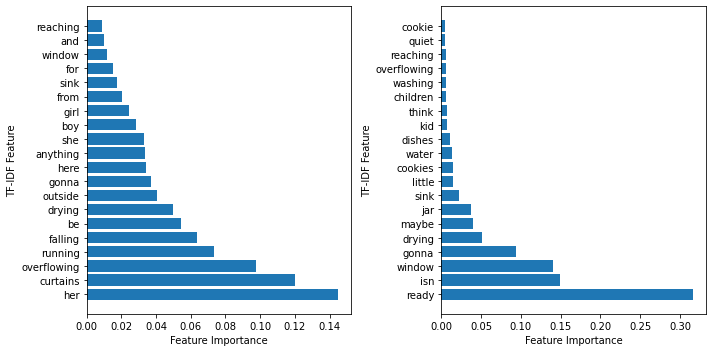

In [251]:
# clf_labels, clf_impor = 
# rgs_labels, rgs_impor =
plt_feats(*feat_impor(clf_xgb_par), * feat_impor(rgs_xgb_par))

## BERT (type) model Experimentaton

In [329]:
# Embedding function
def bert_embed(text: pd.Series, tokenizer, model):
    tokenized = text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512)))

    # pad so can be treated as one batch
    max_len = max([len(i) for i in tokenized.values])
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # attention mask - zero out attention scores where there is no input to be processed (i.e. is padding)
    attention_mask = np.where(padded != 0, 1, 0)
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # check if multiple GPUs are available
    multi_gpu = torch.cuda.device_count() > 1

    if torch.cuda.is_available():
        model = model.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    last_hidden_states = last_hidden_states[0]
    if device.type == 'cuda':
        last_hidden_states = last_hidden_states.cpu()
    features = last_hidden_states[:,0,:].numpy()
    return features

In [327]:
# linear classifier fit/transform
def fit_transform(features, labels: list, mmse: list):
    def cv10_avg_nn(score):
        return cv10_avg(score, lr_clf, features, labels)

    # AD classification task
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=random_state)
    parameters = {'C': np.linspace(0.0001, 100, 20)}
    grid_search = GridSearchCV(LogisticRegression(), parameters)
    grid_search.fit(train_features, train_labels)
    print('best parameters:', grid_search.best_params_)
    print('best scores: ', grid_search.best_score_)
    lr_clf = LogisticRegression(**grid_search.best_params_)
    lr_clf.fit(train_features, train_labels)
    preds = lr_clf.predict(test_features)
    print('prec, rec, f1 test', precision_recall_fscore_support(test_labels, preds))
    print(f'accu:{cv10_avg_nn("accuracy")} prec:{cv10_avg_nn("precision")}, rec:{cv10_avg_nn("recall")}, f1:{cv10_avg_nn("f1")}')
          
    # MMSE regression task
    # remove missing row
    reg_features, reg_scores = pd.DataFrame(features).drop([i for i, s in enumerate(mmse) if s == '']).to_numpy(), [s for s in mmse if s != '']
    train_features, test_features, train_scores, test_scores = train_test_split(reg_features, reg_scores, random_state=random_state)
    parameters = {'alpha': np.linspace(0.001, 100, 20)}
    grid_search = GridSearchCV(Ridge(), parameters)
    grid_search.fit(train_features, train_scores)
    print('best parameters:', grid_search.best_params_)
    print('best scores: ', grid_search.best_score_)
    reg_model = Ridge(**grid_search.best_params_)
    reg_model.fit(train_features, train_scores)
    preds = reg_model.predict(test_features)
    print('rmse test:', sqrt(mean_squared_error(test_scores, preds)))
    print('rmse cv:', cross_val_score(reg_model, reg_features, reg_scores, cv=10, scoring='neg_root_mean_squared_error').sum() / 10)
    return lr_clf, reg_model

In [315]:
# BERT Large
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-uncased')

# roBERTa base
# model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

# roBERTa large
# model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-large')

In [322]:
def load_transformer_model_tokenizer(model_class, tokenizer_class, pretrained_weights):
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    return tokenizer, model

In [325]:
def run_model(model_class, tokenizer_class, pretrained_weights, text):
    tokenizer, model = load_transformer_model_tokenizer(model_class, tokenizer_class, pretrained_weights)
    features = bert_embed(text, tokenizer, model)
    clf_model, reg_model = fit_transform(features, train_df.ad, train_df.mmse)
    return tokenizer, model, features, clf_model, reg_model

In [314]:
# Distil BERT - par speech
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_par_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8279411764705882
prec, rec, f1 test (array([0.81818182, 0.8125    ]), array([0.75      , 0.86666667]), array([0.7826087 , 0.83870968]), array([12, 15]))
accu:0.87 prec:0.9, rec:0.87, f1:0.87
best parameters: {'alpha': 5.264105263157894}
best scores:  0.48426174008121115
rmse test: 5.156365006865598
rmse cv: -4.496598650519269


In [317]:
# Distil roBERTa
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'distilroberta-base')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_par_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8294117647058823
prec, rec, f1 test (array([1.        , 0.88235294]), array([0.83333333, 1.        ]), array([0.90909091, 0.9375    ]), array([12, 15]))
accu:0.84 prec:0.86, rec:0.85, f1:0.82
best parameters: {'alpha': 0.001}
best scores:  0.39129614202351315
rmse test: 5.99993232969807
rmse cv: -5.125356983051849


In [318]:
# BERT Base
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_par_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8294117647058823
prec, rec, f1 test (array([1.        , 0.88235294]), array([0.83333333, 1.        ]), array([0.90909091, 0.9375    ]), array([12, 15]))
accu:0.84 prec:0.86, rec:0.85, f1:0.82
best parameters: {'alpha': 0.001}
best scores:  0.39129614202351315
rmse test: 5.99993232969807
rmse cv: -5.125356983051849


In [326]:
# Distil BERT - par + inv speech
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8147058823529412
prec, rec, f1 test (array([0.90909091, 0.875     ]), array([0.83333333, 0.93333333]), array([0.86956522, 0.90322581]), array([12, 15]))
accu:0.87 prec:0.89, rec:0.89, f1:0.88
best parameters: {'alpha': 5.264105263157894}
best scores:  0.4361080418716384
rmse test: 5.891775312607294
rmse cv: -4.8560381474639875


In [334]:
# BERT Base -  par + inv speech
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8147058823529412
prec, rec, f1 test (array([0.90909091, 0.875     ]), array([0.83333333, 0.93333333]), array([0.86956522, 0.90322581]), array([12, 15]))
accu:0.87 prec:0.89, rec:0.89, f1:0.88
best parameters: {'alpha': 5.264105263157894}
best scores:  0.4361080418716384
rmse test: 5.891775312607294
rmse cv: -4.8560381474639875


In [97]:
# time features
# - Embed time total time taken 
# - parse time blocks, take first and last
# - Embed total time taken per sentence
# - Time before starting speech
# - Time in between each sentence
# - Average / min / max / median time of sentence
time_dims = train_df.loc[:, ['total_time', 'time_before_par_speech', 'time_between_sents', 'per_sent_times']]

In [98]:
time_dims['avg_betweeen_sents'] = time_dims.time_between_sents.apply(lambda t: round(sum(t) / len(t)))
time_dims['max'] = time_dims.time_between_sents.apply(max)
time_dims['min'] = time_dims.time_between_sents.apply(min)
time_dims_eng = time_dims.drop('time_between_sents', axis=1)

In [99]:
time_dims

,total_time,time_before_par_speech,time_between_sents,per_sent_times,avg_betweeen_sents,max,min
0,28249,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[7580, 7580, 2750, 2750, 1670, 1670, 1277, 127...",0,0,0
1,39304,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3700, 2167, 2633, 2633, 3795, 3795, 2785, 278...",0,0,0
2,108061,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2475, 3757, 7084, 7084, 7681, 7681, 3657, 365...",0,0,0
3,70330,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[997, 831, 1014, 1014, 3958, 3958, 3102, 3102,...",0,0,0
4,84322,0,"[0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 0, 0...","[1829, 1064, 3271, 3806, 770, 770, 14216, 1421...",3,100,0
...,...,...,...,...,...,...,...
103,190561,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2913, 11657, 11657, 14986, 14986, 12979, 1297...",49,732,0
104,56600,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1829, 2013, 2013, 558, 558, 1919, 1919, 12302...",0,0,0
105,88250,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1573, 5913, 5913, 2614, 2614, 4376, 4376, 652...",439,10520,0
106,81475,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1853, 6097, 6097, 1512, 1512, 7161, 7161, 610...",34,897,0


In [105]:
len(train_df.clean_par_speech.iloc[0])

7

In [82]:
time_features = StandardScaler().fit_transform(time_dims_eng.to_numpy())

In [ ]:
class BertForADClassification(torch.nn.Module):
    def __init__(self, bertModel, time_dims,):
        super().__init__()
        
        self.bertModel = bertModel
        self.dropout = torch.nn.Dropout(0.5)
        
        # separate Linear for OHE of time
        bert_hidden_dim = self.bertModel
    
        self.classifier = nn.Linear()
    
    def forward(input_ids, attention_mask):
        last_hidden_states = self.bertModel(input_ids, attention_mask=attention_mask)
        features = last_hidden_states[:,0,:]

In [ ]:
# Concat all features
features = np.hstack([bert_features, time_features])

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))